In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.ts_reader import MultiModalDataset,VitalSignsDataset,vital_pre_train
from model.lstm_baseline import *
from model.autoencoder_v1_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()


In [2]:

vital_signs_train = '/home/mei/nas/docker/thesis/data/hdf/train/ts_each_patient.h5'
vital_signs_val = '/home/mei/nas/docker/thesis/data/hdf/val/ts_each_patient.h5'
vital_signs_test = '/home/mei/nas/docker/thesis/data/hdf/test/ts_each_patient.h5'

train_dataset = VitalSignsDataset(vital_signs_train)
val_dataset = VitalSignsDataset(vital_signs_val)
test_dataset = VitalSignsDataset(vital_signs_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=vital_pre_train) 
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=vital_pre_train)

In [3]:
from torch.utils.data import DataLoader, TensorDataset

small_data_iter = iter(train_loader) 
inputs, lengths = next(small_data_iter)   

small_dataset = TensorDataset(inputs, lengths)
small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_features = 154  
embedding_dim = 128
model =BaselineLSTM(n_features, embedding_dim,grid_size=(12,12)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

In [6]:
stage1 = '/home/mei/nas/docker/thesis/data/model_results/lstm_baseline/stage1'
model1, pretrain_history = pretrain_encoder_decoder(
    model, train_loader, device, optimizer, start=1, epochs=100, save_dir=stage1, patience=20
)

[Pretrain] Epoch 10/100, Loss=4.7804, saved checkpoint.
[Pretrain] Epoch 20/100, Loss=4.1383, saved checkpoint.
[Pretrain] Epoch 30/100, Loss=3.7895, saved checkpoint.
[Pretrain] Epoch 40/100, Loss=3.4499, saved checkpoint.
[Pretrain] Epoch 50/100, Loss=3.3678, saved checkpoint.
[Pretrain] Epoch 60/100, Loss=3.3016, saved checkpoint.
[Pretrain] Epoch 70/100, Loss=2.9709, saved checkpoint.
[Pretrain] Epoch 80/100, Loss=2.8887, saved checkpoint.
[Pretrain] Epoch 90/100, Loss=2.7826, saved checkpoint.
[Pretrain] Epoch 100/100, Loss=2.7276, saved checkpoint.


In [8]:
stage1 = '/home/mei/nas/docker/thesis/data/model_results/lstm_baseline/stage1/best_pretrain_model.pth'
## load the best model
model1 =BaselineLSTM(n_features, embedding_dim,grid_size=(12,12)).to(device)
model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

<All keys matched successfully>

In [11]:

lambda_cfg = {
    'kl': 1.0,
    'diversity': 0.05,
    'smooth': 0.03,
    'neighbor': 0.02,
    'l2': 1e-4
}
stage2 = '/home/mei/nas/docker/thesis/data/model_results/lstm_baseline/stage2'
optimizer = optim.Adam(model1.parameters(), lr=1e-3)
model2, joint_history = train_joint(
    model1, train_loader, val_loader, device, optimizer, start=1, epochs=100,
    save_dir=stage2, lambda_cfg=lambda_cfg, patience=40
)

[Joint] Epoch 10/100, Train=3.1205, Val=3.4373
[Joint] Epoch 20/100, Train=2.8816, Val=3.2299
[Joint] Epoch 30/100, Train=2.7827, Val=2.8751
[Joint] Epoch 40/100, Train=2.6277, Val=2.7375
[Joint] Epoch 50/100, Train=2.4335, Val=2.6617
[Joint] Epoch 60/100, Train=2.4244, Val=2.5297
[Joint] Epoch 70/100, Train=2.2844, Val=2.4863
[Joint] Epoch 80/100, Train=2.2745, Val=2.4034
[Joint] Epoch 90/100, Train=2.2455, Val=2.3851
[Joint] Epoch 100/100, Train=2.1692, Val=2.3988


In [5]:
stage2 = '/home/mei/nas/docker/thesis/data/model_results/lstm_baseline/stage2/best_joint_model.pth'
## load the best model
model2 =BaselineLSTM(n_features, embedding_dim,grid_size=(12,12)).to(device)
model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))
## load the history json file
joint_history = json.load(open(stage2.replace('best_joint_model.pth','history_joint.json'), 'r'))

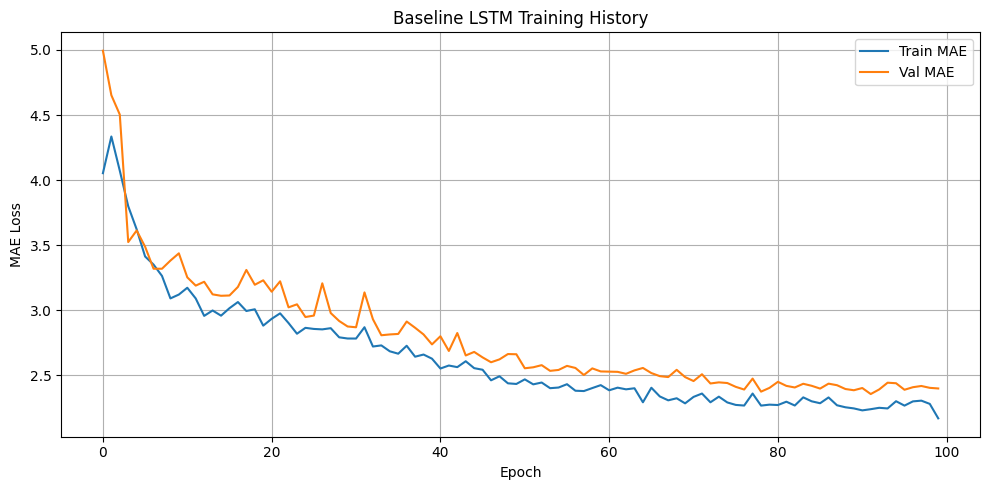

In [12]:
# joint_history = '/home/mei/nas/docker/thesis/data/model_results/lstm_baseline/stage2/history_joint.json'
plot_baseline_history(joint_history)

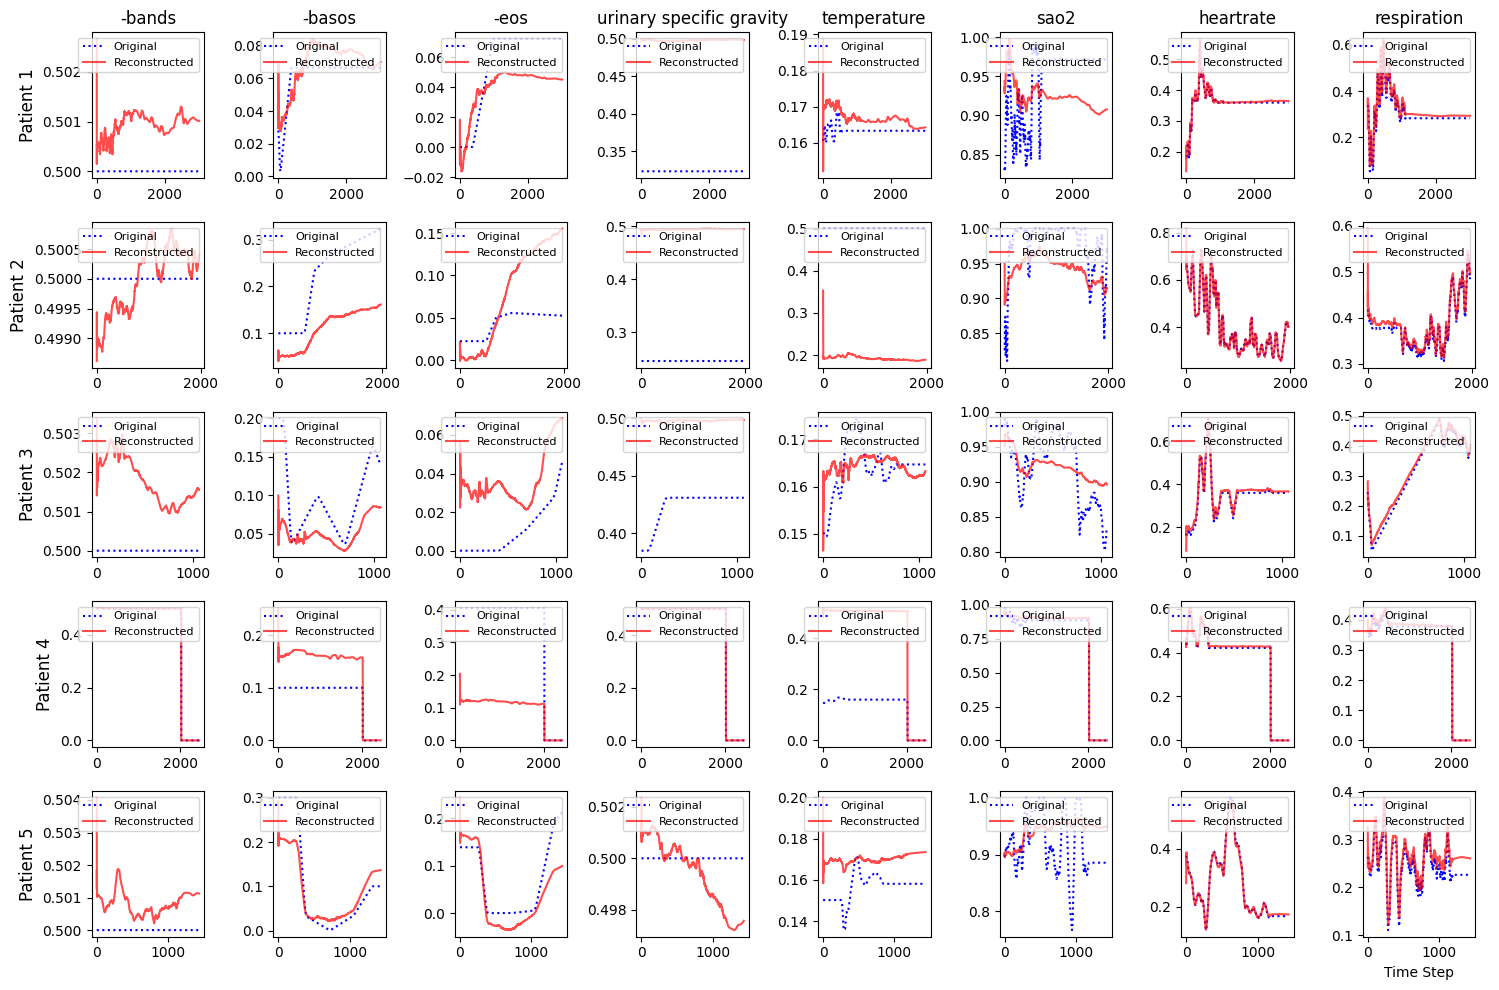

In [13]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model2, test_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)

In [ ]:
save_path = '/home/mei/nas/docker/thesis/data/model_results/pre_train/best_model_baseline.pth'
history_path = '/home/mei/nas/docker/thesis/data/model_results/pre_train/history_baseline.json'
model, history = train_baseline_lstm(model, train_loader, val_loader, optimizer, device, num_epochs=150, save_model_path=save_path, history_path=history_path)

Epoch 10/150 | Train MAE: 0.0296 | Val MAE: 0.0304
Epoch 20/150 | Train MAE: 0.0255 | Val MAE: 0.0266
Epoch 30/150 | Train MAE: 0.0229 | Val MAE: 0.0253
Epoch 40/150 | Train MAE: 0.0204 | Val MAE: 0.0218
Epoch 50/150 | Train MAE: 0.0207 | Val MAE: 0.0226
Epoch 60/150 | Train MAE: 0.0190 | Val MAE: 0.0197
Epoch 70/150 | Train MAE: 0.0175 | Val MAE: 0.0189
Epoch 80/150 | Train MAE: 0.0162 | Val MAE: 0.0180
Epoch 90/150 | Train MAE: 0.0163 | Val MAE: 0.0169
Epoch 100/150 | Train MAE: 0.0154 | Val MAE: 0.0175
Epoch 110/150 | Train MAE: 0.0151 | Val MAE: 0.0168
Epoch 120/150 | Train MAE: 0.0146 | Val MAE: 0.0154
Epoch 130/150 | Train MAE: 0.0147 | Val MAE: 0.0149
Epoch 140/150 | Train MAE: 0.0138 | Val MAE: 0.0148
Epoch 150/150 | Train MAE: 0.0135 | Val MAE: 0.0141
Saved best baseline model to /home/mei/nas/docker/thesis/data/model_results/pre_train/best_model_baseline.pth
Saved baseline training history to /home/mei/nas/docker/thesis/data/model_results/pre_train/history_baseline.json


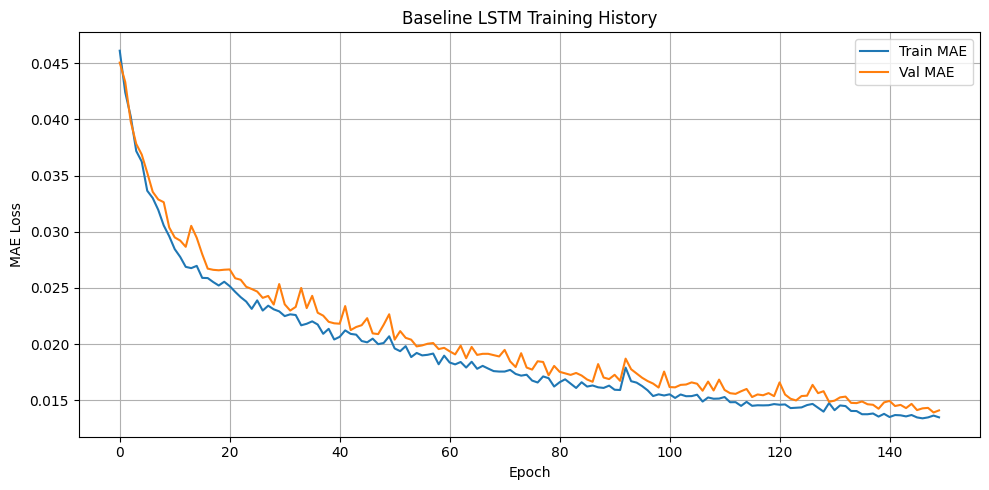

In [12]:
plot_baseline_history(history)

In [13]:
test_baseline_lstm(model, test_loader, device)

Baseline LSTM Test MAE: 0.0130


0.012966465076495862

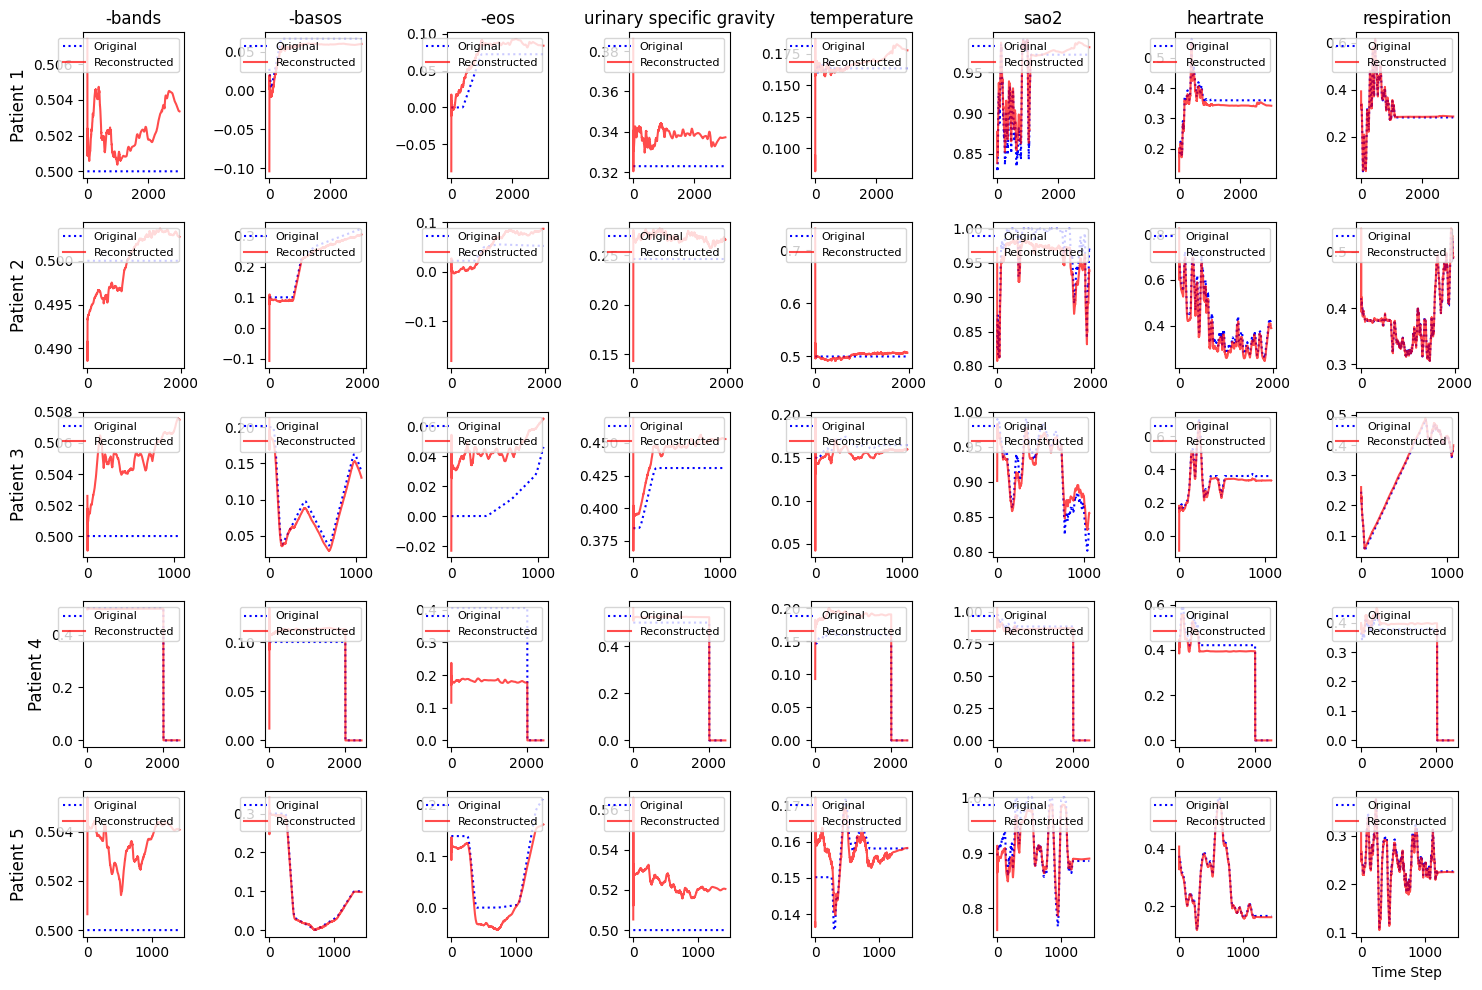

In [15]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model, test_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)